In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
net = nn.Sequential(
    nn.Conv2d(1,96,kernel_size=11,stride=4,padding=1),nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(96, 256, kernel_size=5, padding=2),nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(256,384,kernel_size=3,padding=1), nn.ReLU(),
    nn.Conv2d(384,384,kernel_size=3,padding=1), nn.ReLU(),
    nn.Conv2d(384,256,kernel_size=3,padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2),
    nn.Flatten(),
    nn.Linear(6400,4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096,4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096,10)
    )

In [4]:
X = torch.randn(1,1,224,224)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'Output shape:\t',X.shape)

Conv2d Output shape:	 torch.Size([1, 96, 54, 54])
ReLU Output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d Output shape:	 torch.Size([1, 96, 26, 26])
Conv2d Output shape:	 torch.Size([1, 256, 26, 26])
ReLU Output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d Output shape:	 torch.Size([1, 256, 12, 12])
Conv2d Output shape:	 torch.Size([1, 384, 12, 12])
ReLU Output shape:	 torch.Size([1, 384, 12, 12])
Conv2d Output shape:	 torch.Size([1, 384, 12, 12])
ReLU Output shape:	 torch.Size([1, 384, 12, 12])
Conv2d Output shape:	 torch.Size([1, 256, 12, 12])
ReLU Output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d Output shape:	 torch.Size([1, 256, 5, 5])
Flatten Output shape:	 torch.Size([1, 6400])
Linear Output shape:	 torch.Size([1, 4096])
ReLU Output shape:	 torch.Size([1, 4096])
Dropout Output shape:	 torch.Size([1, 4096])
Linear Output shape:	 torch.Size([1, 4096])
ReLU Output shape:	 torch.Size([1, 4096])
Dropout Output shape:	 torch.Size([1, 4096])
Linear Output shape:	 torch.Size([1,

In [5]:
# 求精确度
def evaluate_accuracy_gpu(net, data_iter, device=None): 
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [6]:
# 在GPU上做训练

def train_ch6(net,train_iter,test_iter,num_epochs,lr,device):
    '''traner defined in chapter 6'''
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
        # 使用xavier初始化，保证rand数据的方差不会太大
    print('trainig on',device)   # 打出来确保在GPU跑
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(),lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch',xlim=[1,num_epochs],
                           legend=['train loss','train acc','test acc'])
    timer,num_batches = d2l.Timer(),len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失和，准确率和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i,(X,y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X,y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat,y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

In [18]:
batch_size = 1
train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size,resize=224)

trainig on cuda:0


RuntimeError: DataLoader worker (pid(s) 20132, 1492, 20428, 4584) exited unexpectedly

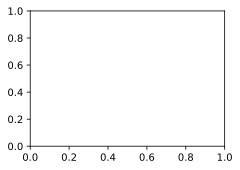

In [19]:
lr, num_epochs = 0.01, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())